Final Project 

KAN-CDSCO2004U  Machine Learning and Deep Learning

Student Names:

- Ísabella Schweitz Ágústsdóttir (175878) 
- Marc Hostettler (176650) 

----


In [1]:
# Core
import pandas as pd
import numpy as np
import time
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Scikit
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    KFold,
    GridSearchCV,
    TimeSeriesSplit,
    RandomizedSearchCV
)
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
# XGBoost
from xgboost import XGBRegressor
# Statsmodels
import statsmodels.api as sm
# scipy
from scipy import stats  



Data Import
----

In [2]:
# Read csv and parse flight date
flights = pd.read_csv('all_flights_data.csv',parse_dates=['FL_DATE'])

# Filter on southwest airlines
sw_flights = flights[flights['AIRLINE'].str.lower() == 'southwest airlines co.']

# Change column names to lower case
sw_flights.columns = sw_flights.columns.str.lower()

# Change name of dataframe for simplicity
df = sw_flights.copy()

# Display the first few rows of the filtered dataframe
df.head()

/var/folders/ch/3p0vl9n50xbfkggjdzry3fxh0000gp/T/ipykernel_24414/2626165635.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('all_flights_data.csv',parse_dates=['FL_DATE'])


,fl_date,airline,airline_dot,airline_code,dot_code,fl_number,origin,origin_city,dest,dest_city,...,diverted,crs_elapsed_time,elapsed_time,air_time,distance,delay_due_carrier,delay_due_weather,delay_due_nas,delay_due_security,delay_due_late_aircraft
16697,2019-12-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1810,HOU,"Houston, TX",DEN,"Denver, CO",...,0.0,155.0,163.0,147.0,883.0,0.0,0.0,8.0,0.0,192.0
16698,2019-12-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,3096,HOU,"Houston, TX",DEN,"Denver, CO",...,0.0,160.0,170.0,148.0,883.0,NaN,NaN,NaN,NaN,NaN
16699,2019-12-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,3172,HOU,"Houston, TX",DEN,"Denver, CO",...,0.0,155.0,170.0,155.0,883.0,0.0,0.0,15.0,8.0,0.0
16700,2019-12-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,2508,HOU,"Houston, TX",ECP,"Panama City, FL",...,0.0,95.0,82.0,73.0,571.0,NaN,NaN,NaN,NaN,NaN
16701,2019-12-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,402,HOU,"Houston, TX",ELP,"El Paso, TX",...,0.0,120.0,119.0,109.0,677.0,NaN,NaN,NaN,NaN,NaN


Exporatory Data Analysis & Data Cleaning
----

In [3]:
# Fetch min and max dates
min_date = df['fl_date'].min()
max_date = df['fl_date'].max()
print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

Min date: 2019-01-01 00:00:00
Max date: 2023-08-31 00:00:00


In [4]:
# Analyze the shape of the dataframe
df.shape

(5638744, 32)

In [5]:
# Show all column names and their data types
df.dtypes

fl_date                    datetime64[ns]
airline                            object
airline_dot                        object
airline_code                       object
dot_code                            int64
fl_number                           int64
origin                             object
origin_city                        object
dest                               object
dest_city                          object
crs_dep_time                        int64
dep_time                          float64
dep_delay                         float64
taxi_out                          float64
wheels_off                        float64
wheels_on                         float64
taxi_in                           float64
crs_arr_time                        int64
arr_time                          float64
arr_delay                         float64
cancelled                         float64
cancellation_code                  object
diverted                          float64
crs_elapsed_time                  

In [6]:
# Fetch info and summary
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Index: 5638744 entries, 16697 to 29356001
Data columns (total 32 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   fl_date                  datetime64[ns]
 1   airline                  object        
 2   airline_dot              object        
 3   airline_code             object        
 4   dot_code                 int64         
 5   fl_number                int64         
 6   origin                   object        
 7   origin_city              object        
 8   dest                     object        
 9   dest_city                object        
 10  crs_dep_time             int64         
 11  dep_time                 float64       
 12  dep_delay                float64       
 13  taxi_out                 float64       
 14  wheels_off               float64       
 15  wheels_on                float64       
 16  taxi_in                  float64       
 17  crs_arr_time             in

In [7]:
# Check for missing values % and order by highest to lowest
missing = df.isnull().sum() / len(df) * 100
missing = missing[missing > 0].sort_values(ascending=False)
missing = missing.to_frame(name='Missing Values %')
missing

,Missing Values %
cancellation_code,96.631307
delay_due_carrier,81.398535
delay_due_weather,81.398535
delay_due_nas,81.398535
delay_due_security,81.398535
delay_due_late_aircraft,81.398535
arr_delay,3.565173
elapsed_time,3.565173
air_time,3.565173
wheels_on,3.395065


In [8]:
# Extract the distribution of cancellations and diverted flights to get a better sense of the data
cancellation_values = df['cancelled'].value_counts()
diversion_values = df['diverted'].value_counts()

# Show as percentage
perc_cancellation_values = df['cancelled'].value_counts(normalize=True) * 100
perc_diversion_values = df['diverted'].value_counts(normalize=True) * 100

print(f'Cancellation values: {cancellation_values}')
print(f'Cancellation value %: {perc_cancellation_values}')
print(f'Diversion values: {diversion_values}')
print(f'Diversion value %: {perc_diversion_values}')

Cancellation values: cancelled
0.0    5448792
1.0     189952
Name: count, dtype: int64
Cancellation value %: cancelled
0.0    96.631307
1.0     3.368693
Name: proportion, dtype: float64
Diversion values: diverted
0.0    5627665
1.0      11079
Name: count, dtype: int64
Diversion value %: diverted
0.0    99.80352
1.0     0.19648
Name: proportion, dtype: float64


In [9]:
# Check duplicate rows using composite key (fl_date, fl_number, origin, dest)
duplicates = df.duplicated(subset=['fl_date', 'fl_number', 'origin', 'dest'])
print(duplicates.sum())

0


In [10]:
# Drop cancelled/diverted flights
df = df[(df['cancelled'] == 0) & (df['diverted'] == 0)]

Correlation with arrival delay:
arr_delay                  1.000000
dep_delay                  0.943358
delay_due_late_aircraft    0.636930
delay_due_carrier          0.495072
dep_time                   0.248571
wheels_off                 0.241002
delay_due_nas              0.235589
taxi_out                   0.232451
crs_dep_time               0.210319
delay_due_weather          0.201402
crs_arr_time               0.153169
taxi_in                    0.153141
wheels_on                  0.080903
arr_time                   0.072211
elapsed_time               0.070136
delay_due_security         0.043266
air_time                   0.032268
distance                   0.011345
fl_number                  0.005808
crs_elapsed_time          -0.003121
dot_code                        NaN
cancelled                       NaN
diverted                        NaN
Name: arr_delay, dtype: float64 



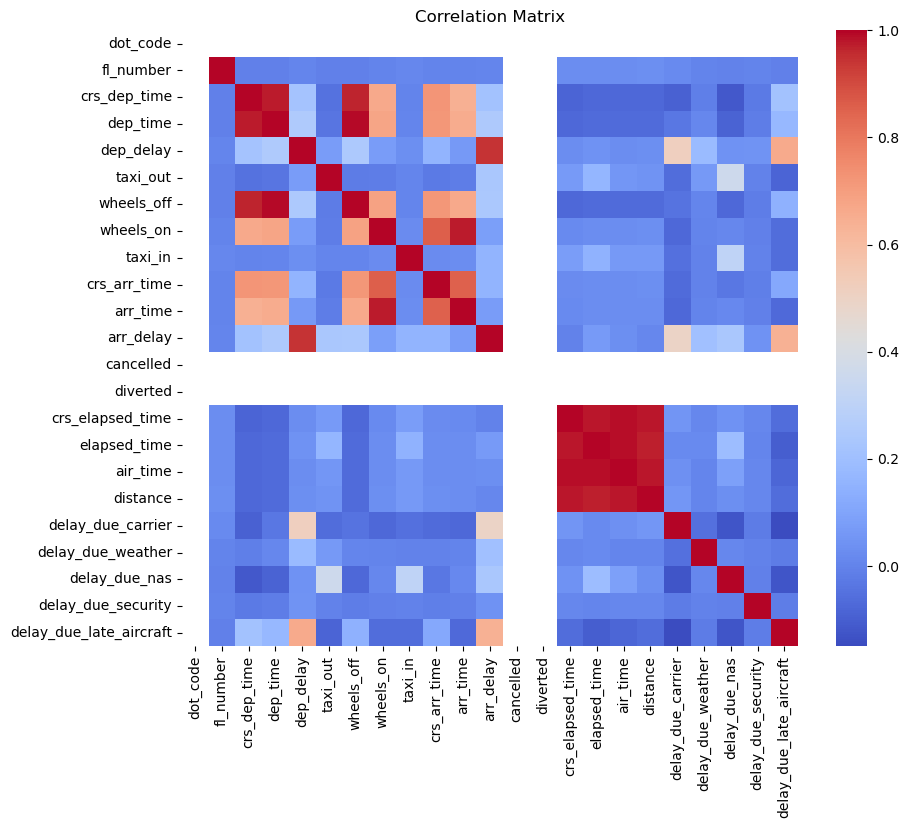

In [11]:
# Display the linear relationship between the delays and other numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
print("Correlation with arrival delay:")
print(corr_matrix['arr_delay'].sort_values(ascending=False), "\n")

# Visualise using a correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

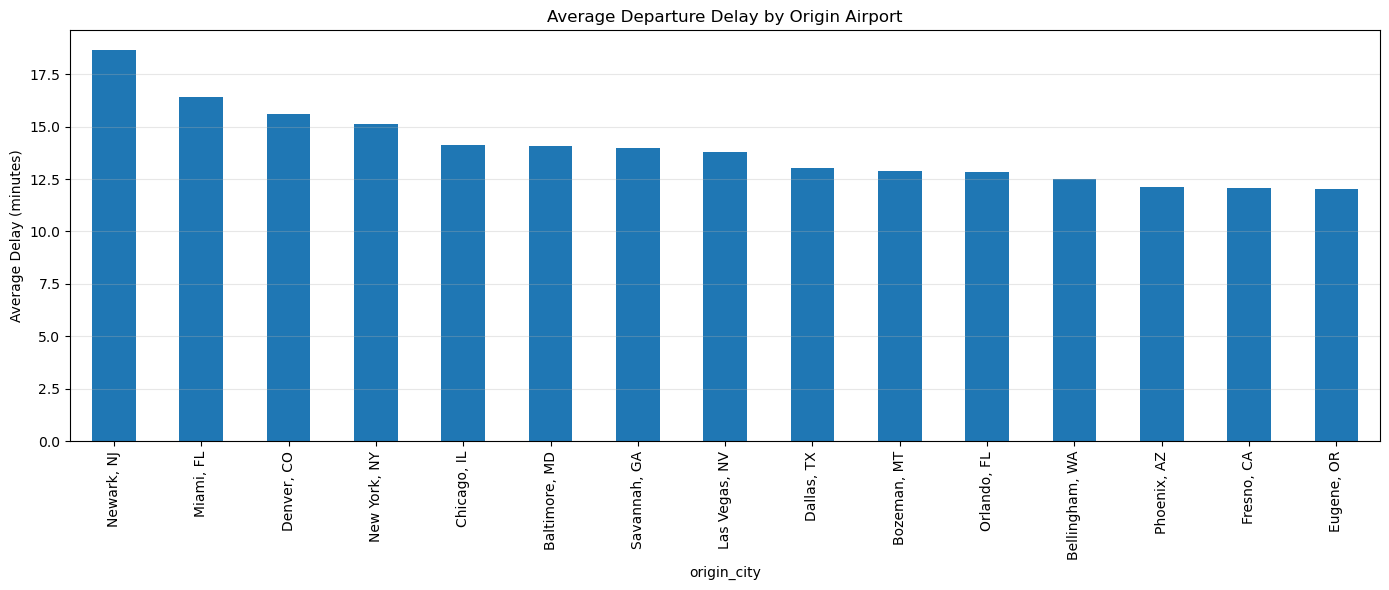

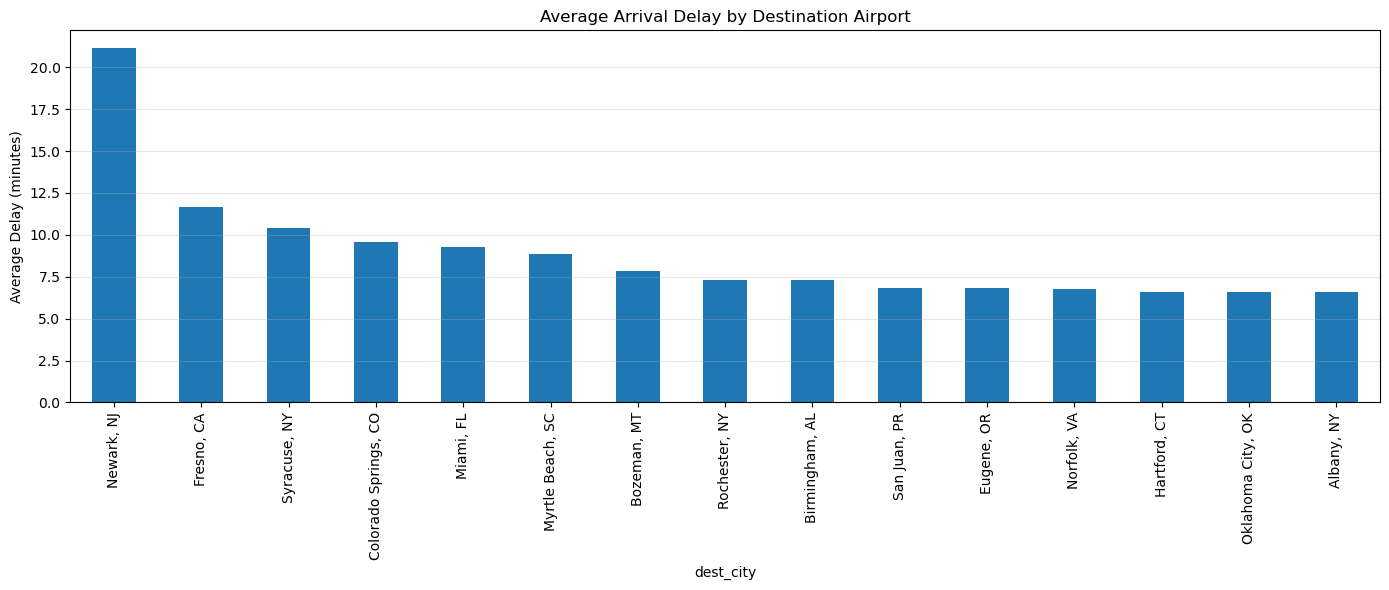

In [12]:
# Compare the types of delays based on the origin and departure airport, and visualise by city to get an understanding of the difference between the dep_delay+origin and arr_delay+destination 

# Airports with most delays based on departure delay and origin airport
plt.figure(figsize=(14, 6))
df.groupby('origin_city')['dep_delay'].mean().sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Average Departure Delay by Origin Airport')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Airports with most delays based on arrival delay and destination airport
plt.figure(figsize=(14, 6))
df.groupby('dest_city')['arr_delay'].mean().sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Average Arrival Delay by Destination Airport')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# Analyse the difference between the mean for all arrival delays and positive arrival delays
# We fetch mean of arr_delay
mean_arr_delay = df['arr_delay'].mean()
print(f"Mean Arrival Delay: {mean_arr_delay:.2f} minutes")

# We fetch the mean of arr_delay where arr_delay > 0
mean_arr_delay_positive = df[df['arr_delay'] > 0]['arr_delay'].mean()
print(f"Mean Arrival Delay (positive values): {mean_arr_delay_positive:.2f} minutes")

Mean Arrival Delay: 3.25 minutes
Mean Arrival Delay (positive values): 30.21 minutes


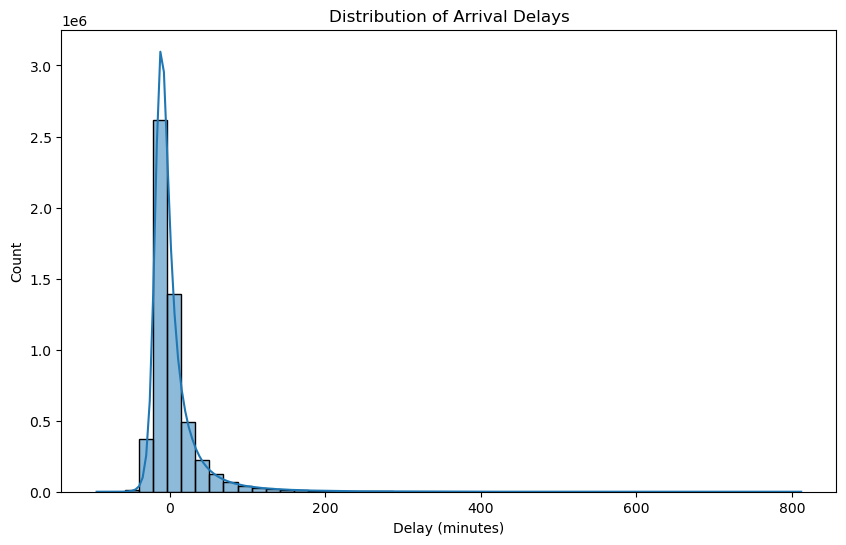

In [ ]:
# Show arrival delay distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['arr_delay'].dropna(), bins=50, kde=True)
plt.title('Distribution of Arrival Delays')
plt.xlabel('Delay (minutes)') 
plt.show()

In [15]:
# Allocate delay into buckets to understand the distribution of delays
# Define bins that include both early arrivals and delays
max_delay = int(df['arr_delay'].max() // 50 * 50 + 50)
min_delay = int(df['arr_delay'].min() // 50 * 50 - 50)  
bins = np.arange(min_delay, max_delay + 1, 50)
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
df['delay_bucket'] = pd.cut(df['arr_delay'], bins=bins, labels=labels, right=False, include_lowest=True)

# Calculate counts and percentages
bucket_counts = df['delay_bucket'].value_counts().sort_index()
bucket_stats = bucket_counts.rename_axis('delay_range').reset_index(name='count')
bucket_stats['percentage'] = (bucket_stats['count'] / bucket_stats['count'].sum()) * 100

print("Delay/Early bucket counts and percentages:")
print(bucket_stats)

Delay/Early bucket counts and percentages:
   delay_range    count  percentage
0    -150--100        0    0.000000
1     -100--50     1202    0.022105
2        -50-0  3360599   61.801699
3         0-50  1731456   31.841622
4       50-100   227364    4.181243
5      100-150    68741    1.264153
6      150-200    27176    0.499769
7      200-250    11799    0.216985
8      250-300     5183    0.095316
9      300-350     2404    0.044210
10     350-400     1002    0.018427
11     400-450      458    0.008423
12     450-500      183    0.003365
13     500-550       87    0.001600
14     550-600       36    0.000662
15     600-650       11    0.000202
16     650-700        6    0.000110
17     700-750        2    0.000037
18     750-800        1    0.000018
19     800-850        3    0.000055


**Outlier Analysis**

In [16]:
# Compute the 99.5th percentile cutoff
p = 0.995
cutoff = df['arr_delay'].quantile(p)
print(f"{p*100:.1f}th percentile cutoff for arr_delay: {cutoff:.0f} minutes")

# Select the flights above that cutoff
outliers = df[df['arr_delay'] > cutoff]

# Inspect how many and see a sample sorted by delay
print(f"Flights exceeding the cutoff: {len(outliers)} ({100*(len(outliers)/len(df)):.2f}% of data)\n")

# Show the 10 worst delays
print(outliers[['fl_date', 'origin', 'dest', 'arr_delay']]
      .sort_values(by='arr_delay', ascending=False)
      .head(10))

# Show the 10 least-extreme delays
print("\nExample of least‐extreme outliers:")
print(outliers[['fl_date', 'origin', 'dest', 'arr_delay']]
      .sort_values(by='arr_delay')
      .head(10))

# Pattern analysis

# Group the count of outliers by dates and order by most to least to see if there are any patterns
outliers_by_date = outliers.groupby('fl_date').size().reset_index(name='count')
outliers_by_date = outliers_by_date.sort_values(by='count', ascending=False)
print("Outliers by date:")
print(outliers_by_date.head(10))

# Group the count of outliers by origin and order by most to least to see if there are any patterns
outliers_by_origin = outliers.groupby('origin').size().reset_index(name='count')
outliers_by_origin = outliers_by_origin.sort_values(by='count', ascending=False)
print("Outliers by origin:")
print(outliers_by_origin.head(10))

# Group the count of outliers by destination and order by most to least to see if there are any patterns
outliers_by_dest = outliers.groupby('dest').size().reset_index(name='count')
outliers_by_dest = outliers_by_dest.sort_values(by='count', ascending=False)
print("Outliers by destination:")
print(outliers_by_dest.head(10))

99.5th percentile cutoff for arr_delay: 184 minutes
Flights exceeding the cutoff: 27134 (0.50% of data)

            fl_date origin dest  arr_delay
27513745 2023-01-31    DAL  LGA      812.0
27513776 2023-01-31    DAL  MIA      810.0
4423550  2019-04-11    MSP  BWI      809.0
29334226 2023-08-06    RIC  ATL      760.0
20130563 2022-07-18    BNA  BWI      731.0
23907048 2022-12-22    DEN  GEG      714.0
18966811 2022-04-02    TPA  MDW      697.0
23854453 2022-12-26    TPA  ORD      691.0
28070027 2023-03-06    BHM  MCO      667.0
27513828 2023-01-31    DAL  STL      655.0

Example of least‐extreme outliers:
            fl_date origin dest  arr_delay
836894   2019-10-31    DEN  SJC      185.0
19630175 2022-06-23    SJU  MCO      185.0
27465888 2023-01-11    LGA  MDW      185.0
4414712  2019-04-04    MDW  TPA      185.0
19635448 2022-06-25    ELP  DAL      185.0
25373904 2023-06-22    DEN  DAL      185.0
25373732 2023-06-22    DAL  MDW      185.0
20120890 2022-07-09    MCO  BWI      185.0

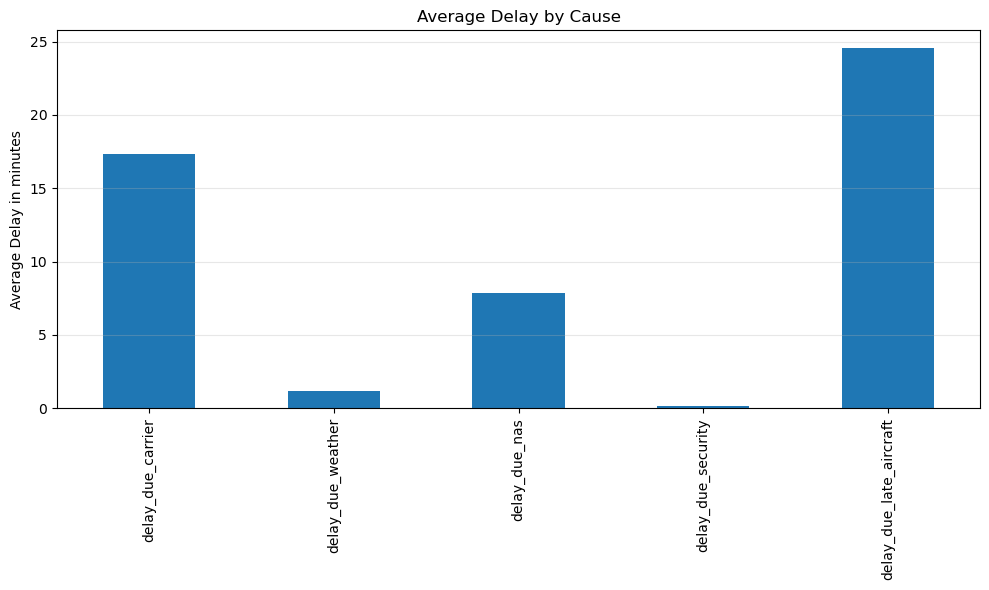

In [17]:
# Analysis of the average delay by causes known after flight 
delay_causes = ['delay_due_carrier', 'delay_due_weather', 'delay_due_nas', 'delay_due_security', 'delay_due_late_aircraft']
if all(cause in df.columns for cause in delay_causes):
    delays_df = df[delay_causes].mean()
    plt.figure(figsize=(10, 6))
    delays_df.plot(kind='bar')
    plt.title('Average Delay by Cause')
    plt.ylabel('Average Delay in minutes')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout() 
    plt.show()

Feature Engineering
-----

In [18]:
# Create functions to convert hhmm to timedelta and add cyclic hour features
def hhmm_to_timedelta(col: pd.Series) -> pd.Series:
    col = (
        pd.to_numeric(col, errors='coerce')
          .astype('Int64')                             
          .apply(lambda x: f"{int(x):04d}" if pd.notnull(x) else np.nan) 
    )
    return (pd.to_timedelta(col.str[:2].astype(float), unit='h') +
            pd.to_timedelta(col.str[2:].astype(float), unit='m'))

def add_cyclic_hour(df: pd.DataFrame, td_col: str, prefix: str) -> None:
    df[f'{prefix}_hour'] = df[td_col].dt.seconds // 3600
    df[f'{prefix}_sin']  = np.sin(2 * np.pi * df[f'{prefix}_hour'] / 24)
    df[f'{prefix}_cos']  = np.cos(2 * np.pi * df[f'{prefix}_hour'] / 24)

# Create prefix for new columns
hhmm_cols = {
    'crs_dep_time': 'sched_dep',
    'crs_arr_time': 'sched_arr',
    'wheels_off'  : 'wheels_off',
    'dep_time'    : 'act_dep',
}

for col, prefix in hhmm_cols.items():
    td_col = f'{col}_td'               
    df[td_col] = hhmm_to_timedelta(df[col])
    add_cyclic_hour(df, td_col, prefix)

# Create sinus and cosine features for day of week and month
df['day_of_week'] = df['fl_date'].dt.dayofweek                      
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['year']  = df['fl_date'].dt.year

df['month'] = df['fl_date'].dt.month
df['mon_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['mon_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# Create a feature for weekend
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Convert crs_elapsed_time to numeric
df['crs_elapsed_time'] = pd.to_numeric(df['crs_elapsed_time'], errors='coerce')


In [ ]:
# Check on new features
df[['crs_dep_time_td','sched_dep_hour','sched_dep_sin','sched_dep_cos',
    'crs_arr_time_td','sched_arr_hour','sched_arr_sin','sched_arr_cos',
    'wheels_off','wheels_off_hour','wheels_off_sin','wheels_off_cos',
    'dep_time','act_dep_hour','act_dep_sin','act_dep_cos']].head()

,crs_dep_time_td,sched_dep_hour,sched_dep_sin,sched_dep_cos,crs_arr_time_td,sched_arr_hour,sched_arr_sin,sched_arr_cos,wheels_off,wheels_off_hour,wheels_off_sin,wheels_off_cos,dep_time,act_dep_hour,act_dep_sin,act_dep_cos
16697,0 days 19:45:00,19,-0.965926,0.258819,0 days 21:20:00,21,-7.071068e-01,7.071068e-01,2307.0,23,-0.258819,0.965926,2257.0,22,-0.500000,0.866025
16698,0 days 10:45:00,10,0.500000,-0.866025,0 days 12:25:00,12,1.224647e-16,-1.000000e+00,1103.0,11,0.258819,-0.965926,1045.0,10,0.500000,-0.866025
16699,0 days 13:55:00,13,-0.258819,-0.965926,0 days 15:30:00,15,-7.071068e-01,-7.071068e-01,1412.0,14,-0.500000,-0.866025,1403.0,14,-0.500000,-0.866025
16700,0 days 16:55:00,16,-0.866025,-0.500000,0 days 18:30:00,18,-1.000000e+00,-1.836970e-16,1656.0,16,-0.866025,-0.500000,1649.0,16,-0.866025,-0.500000
16701,0 days 08:30:00,8,0.866025,-0.500000,0 days 09:30:00,9,7.071068e-01,-7.071068e-01,830.0,8,0.866025,-0.500000,823.0,8,0.866025,-0.500000


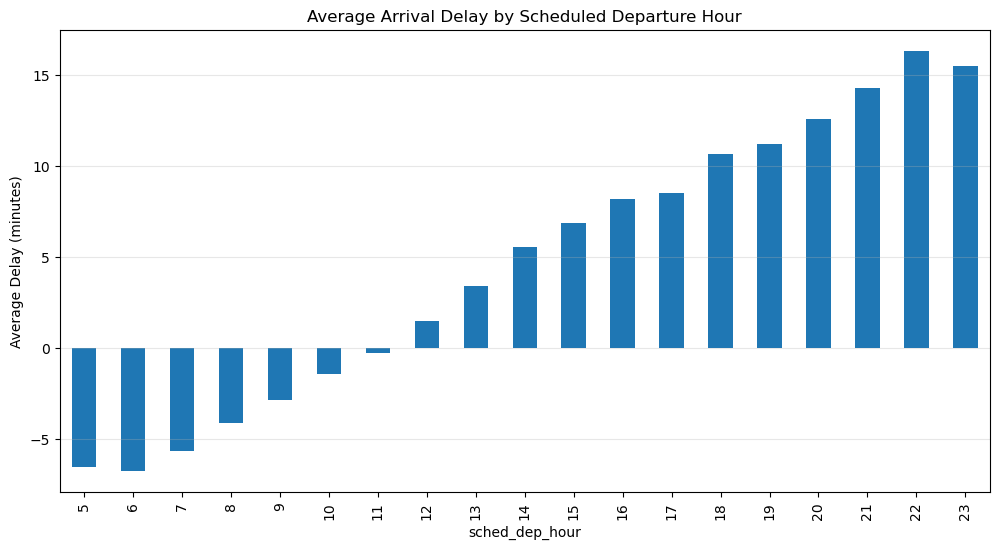

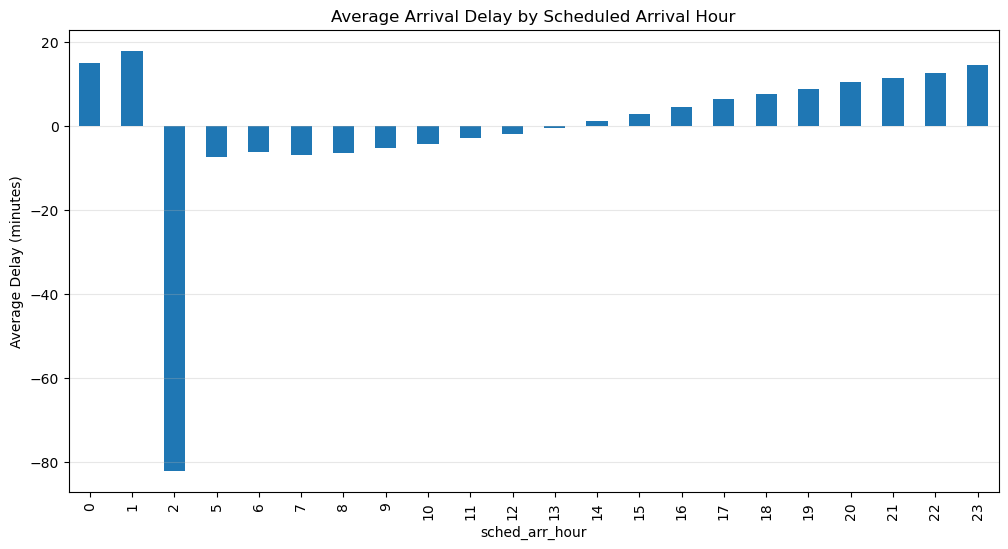

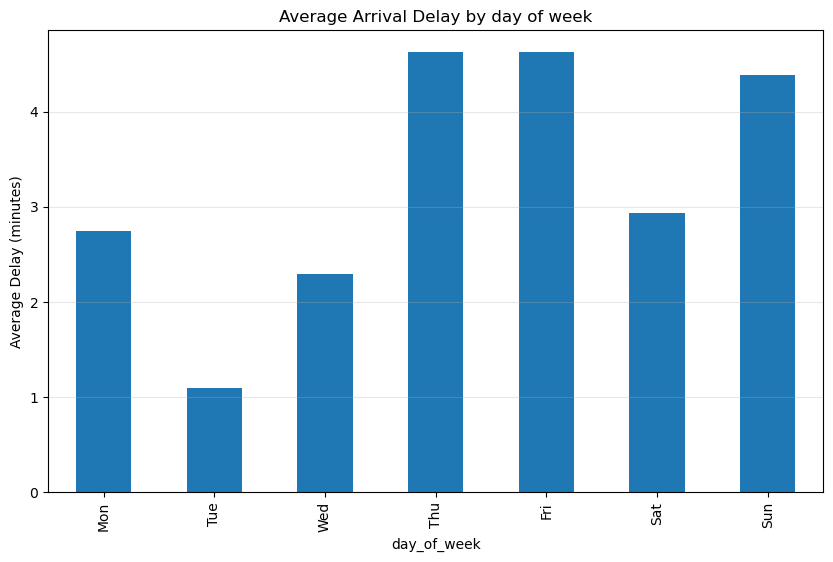

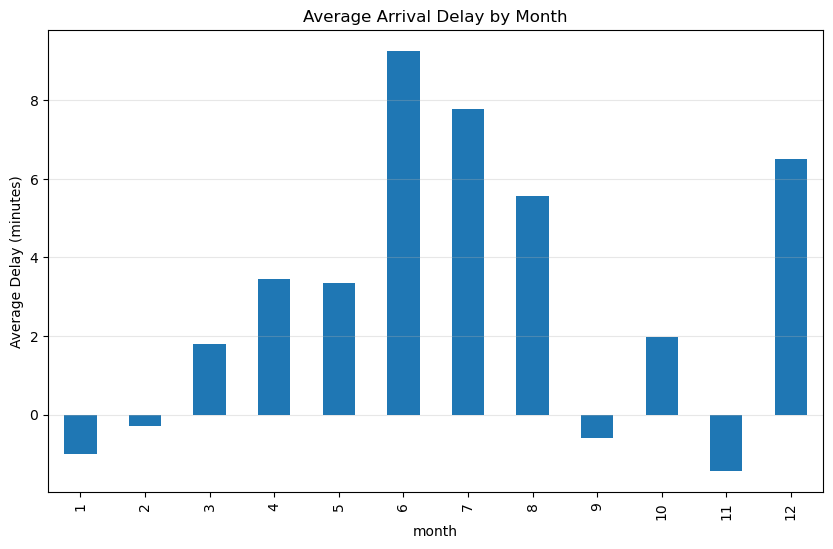

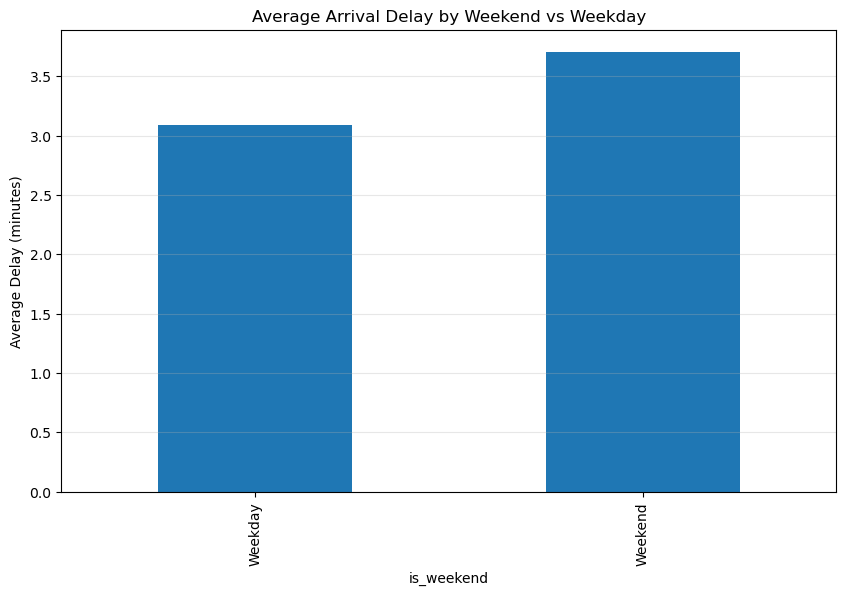

In [20]:
# Analysing to get a better understanding of the delay behavior

# Time-based analysis
# Scheduled departure hour analysis
plt.figure(figsize=(12, 6))
df.groupby('sched_dep_hour')['arr_delay'].mean().plot(kind='bar')
plt.title('Average Arrival Delay by Scheduled Departure Hour')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Scheduled arrival hour analysis
plt.figure(figsize=(12, 6))
df.groupby('sched_arr_hour')['arr_delay'].mean().plot(kind='bar')
plt.title('Average Arrival Delay by Scheduled Arrival Hour')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Day of week analysis
plt.figure(figsize=(10, 6))
df.groupby('day_of_week')['arr_delay'].mean().plot(kind='bar')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Average Arrival Delay by day of week')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Month analysis
plt.figure(figsize=(10, 6))
df.groupby('month')['arr_delay'].mean().plot(kind='bar')
plt.title('Average Arrival Delay by Month')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Weekday vs weekend analysis
plt.figure(figsize=(10, 6))
df.groupby('is_weekend')['arr_delay'].mean().plot(kind='bar')
plt.title('Average Arrival Delay by Weekend vs Weekday')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
plt.show()

<Figure size 1200x600 with 0 Axes>

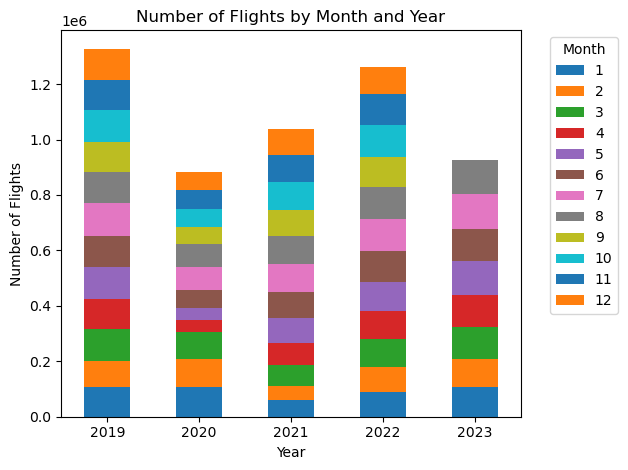

In [21]:
# Visualise the number of flights by month and year
plt.figure(figsize=(12, 6))
df.groupby(['year', 'month']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Number of Flights by Month and Year')
plt.ylabel('Number of Flights')
plt.xlabel('Year')
plt.xticks(rotation=0)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# Fetch number of unique values for each column
df.nunique()

fl_date                    1704
airline                       1
airline_dot                   1
airline_code                  1
dot_code                      1
fl_number                  6939
origin                      108
origin_city                 105
dest                        108
dest_city                   105
crs_dep_time                228
dep_time                   1370
dep_delay                   628
taxi_out                    173
wheels_off                 1377
wheels_on                  1440
taxi_in                     178
crs_arr_time                245
arr_time                   1440
arr_delay                   672
cancelled                     1
cancellation_code             0
diverted                      1
crs_elapsed_time             83
elapsed_time                447
air_time                    410
distance                    790
delay_due_carrier           531
delay_due_weather           418
delay_due_nas               433
delay_due_security          239
delay_du

In [25]:
# Create route column
df['route'] = df['origin'] + '_' + df['dest']

# Add variable for covid (year = 2020) called is_covid
df['is_covid'] = (df['year'] == 2020).astype(int)

Model Data Preparation
-----

In [ ]:
# Feature preparation
raw_feats = [
    'origin', 'dest', 'route',
    'sched_dep_sin', 'sched_dep_cos', 'sched_arr_sin', 'sched_arr_cos',
    'dow_sin', 'dow_cos', 'mon_sin', 'mon_cos', 'is_weekend',
    'distance', 'crs_elapsed_time', 'year', 'is_covid',
    'dep_delay', 'taxi_out', 'act_dep_sin', 'act_dep_cos',
    'wheels_off_sin', 'wheels_off_cos'          
]
X = df[raw_feats].copy()
y = df['arr_delay']            

# Train and test split by year
train_mask = df['year'] < 2023
test_mask  = df['year'] == 2023

X_train, y_train = X.loc[train_mask].copy(), y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask].copy(),  y.loc[test_mask]

# Out of fold mean-delay encoding

# We need the flight date to keep rows in true chronological order.
X_train['fl_date'] = df.loc[X_train.index, 'fl_date']
X_train = X_train.sort_values('fl_date')          
y_train = y_train.loc[X_train.index]    

enc_cols = ['origin', 'dest', 'route']
for col in enc_cols:
    X_train[f'{col}_delay_enc'] = np.nan         
    
# TimeSeriesSplit is used due to underlying trends, and seasonality. 
tscv = TimeSeriesSplit(n_splits=5)
for past_pos, future_pos in tscv.split(X_train):
    past_idx   = X_train.index[past_pos]          # rows before cut off
    future_idx = X_train.index[future_pos]        # hold-out wors

    # Compute means using past
    for col in enc_cols:
        means = (
            y_train.loc[past_idx]
            .groupby(X_train.loc[past_idx, col])
            .mean()
        )

        # Write the means into the future fold
        X_train.loc[future_idx, f'{col}_delay_enc'] = (
            X_train.loc[future_idx, col].map(means)
        )

# Any category we’ve never seen before gets the global mean delay
global_mean = y_train.mean()
for col in enc_cols:
    X_train[f'{col}_delay_enc'].fillna(global_mean, inplace=True)

# Encode test set using the training set means
for col in enc_cols:
    past_means = y_train.groupby(X_train[col]).mean()   # full training history
    X_test[f'{col}_delay_enc'] = (
        X_test[col].map(past_means).fillna(global_mean)
    )

X_train.drop(columns=enc_cols + ['fl_date'], inplace=True)
X_test.drop(columns=enc_cols, inplace=True)             

numeric_feats_q1 = [
    'sched_dep_sin', 'sched_dep_cos', 'sched_arr_sin', 'sched_arr_cos',
    'dow_sin', 'dow_cos', 'mon_sin', 'mon_cos', 'is_weekend',
    'distance', 'crs_elapsed_time',
    'origin_delay_enc', 'dest_delay_enc', 'route_delay_enc',
    'year', 'is_covid'
]

numeric_feats_q2 = [
    'sched_dep_sin', 'sched_dep_cos', 'sched_arr_sin', 'sched_arr_cos',
    'dow_sin', 'dow_cos', 'mon_sin', 'mon_cos', 'is_weekend',
    'distance', 'crs_elapsed_time',
    'origin_delay_enc', 'dest_delay_enc', 'route_delay_enc',
    'year', 'is_covid',
    'dep_delay', 'taxi_out', 'act_dep_sin', 'act_dep_cos',
    'wheels_off_sin', 'wheels_off_cos'
]

X_train_q1 = X_train[numeric_feats_q1]
X_test_q1  = X_test [numeric_feats_q1]
X_train_q2 = X_train[numeric_feats_q2]
X_test_q2  = X_test [numeric_feats_q2]


/var/folders/ch/3p0vl9n50xbfkggjdzry3fxh0000gp/T/ipykernel_24414/1876748167.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[f'{col}_delay_enc'].fillna(global_mean, inplace=True)


In [27]:
# Fetch mean for origin_delay_enc, dest_delay_enc, and route_delay_enc
mean_origin_delay_enc = X_train['origin_delay_enc'].mean()
mean_dest_delay_enc = X_train['dest_delay_enc'].mean()
mean_route_delay_enc = X_train['route_delay_enc'].mean()
print(f"Mean Origin Delay Encoding: {mean_origin_delay_enc:.2f}")
print(f"Mean Destination Delay Encoding: {mean_dest_delay_enc:.2f}")
print(f"Mean Route Delay Encoding: {mean_route_delay_enc:.2f}")

Mean Origin Delay Encoding: 1.27
Mean Destination Delay Encoding: 1.20
Mean Route Delay Encoding: 1.34


In [28]:
# Confirm imputation is not needed
X_train_q1[numeric_feats_q1].isnull().sum()

sched_dep_sin       0
sched_dep_cos       0
sched_arr_sin       0
sched_arr_cos       0
dow_sin             0
dow_cos             0
mon_sin             0
mon_cos             0
is_weekend          0
distance            0
crs_elapsed_time    0
origin_delay_enc    0
dest_delay_enc      0
route_delay_enc     0
year                0
is_covid            0
dtype: int64

In [29]:
# Confirm imputation is not needed
X_train_q2[numeric_feats_q2].isnull().sum()

sched_dep_sin       0
sched_dep_cos       0
sched_arr_sin       0
sched_arr_cos       0
dow_sin             0
dow_cos             0
mon_sin             0
mon_cos             0
is_weekend          0
distance            0
crs_elapsed_time    0
origin_delay_enc    0
dest_delay_enc      0
route_delay_enc     0
year                0
is_covid            0
dep_delay           0
taxi_out            0
act_dep_sin         0
act_dep_cos         0
wheels_off_sin      0
wheels_off_cos      0
dtype: int64

In [ ]:
# Define columns to scale
scale_common = ['distance', 'crs_elapsed_time']          # q1 and q2
scale_extra  = ['dep_delay', 'taxi_out']                 # q2 only

# Pre-processor for Q1
passthrough_q1 = [c for c in numeric_feats_q1 if c not in scale_common]

preprocessor_q1 = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale_common),
        ('keep',  'passthrough',   passthrough_q1)
    ],
    remainder='drop'
)

# Fit on q1
preprocessor_q1.fit(X_train_q1)

# Transform and cache
X_train_q1_proc = preprocessor_q1.transform(X_train_q1)
X_test_q1_proc  = preprocessor_q1.transform(X_test_q1)

feat_names_q1 = preprocessor_q1.get_feature_names_out()
print("Q1 transformed columns:", feat_names_q1)

# Pre-processor for Q2
scale_q2 = scale_common + scale_extra
passthrough_q2 = [c for c in numeric_feats_q2 if c not in scale_q2]

preprocessor_q2 = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale_q2),
        ('keep',  'passthrough',   passthrough_q2)
    ],
    remainder='drop'
)

# Fit on q2
preprocessor_q2.fit(X_train_q2)

# Transform and cache
X_train_q2_proc = preprocessor_q2.transform(X_train_q2)
X_test_q2_proc  = preprocessor_q2.transform(X_test_q2)

feat_names_q2 = preprocessor_q2.get_feature_names_out()
print("Q2 transformed columns:", feat_names_q2)


Q1 transformed columns: ['scale__distance' 'scale__crs_elapsed_time' 'keep__sched_dep_sin'
 'keep__sched_dep_cos' 'keep__sched_arr_sin' 'keep__sched_arr_cos'
 'keep__dow_sin' 'keep__dow_cos' 'keep__mon_sin' 'keep__mon_cos'
 'keep__is_weekend' 'keep__origin_delay_enc' 'keep__dest_delay_enc'
 'keep__route_delay_enc' 'keep__year' 'keep__is_covid']
Q2 transformed columns: ['scale__distance' 'scale__crs_elapsed_time' 'scale__dep_delay'
 'scale__taxi_out' 'keep__sched_dep_sin' 'keep__sched_dep_cos'
 'keep__sched_arr_sin' 'keep__sched_arr_cos' 'keep__dow_sin'
 'keep__dow_cos' 'keep__mon_sin' 'keep__mon_cos' 'keep__is_weekend'
 'keep__origin_delay_enc' 'keep__dest_delay_enc' 'keep__route_delay_enc'
 'keep__year' 'keep__is_covid' 'keep__act_dep_sin' 'keep__act_dep_cos'
 'keep__wheels_off_sin' 'keep__wheels_off_cos']


Modelling
----

**Baseline Model**

In [ ]:
# Baseline is a dummy regressor that predicts the mean of the training set, same for q1 and q2
def evaluate_dummy(X_tr, y_tr, X_te, y_te, label):
    dummy = DummyRegressor(strategy="mean")          # predicts training‑set mean
    dummy.fit(X_tr, y_tr)
    y_pred = dummy.predict(X_te)

    rmse = mean_squared_error(y_te, y_pred, squared=False)
    mae  = mean_absolute_error(y_te, y_pred)
    r2   = r2_score(y_te, y_pred)

    print(f"{label} – Dummy baseline")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAE : {mae :.2f}")
    print(f"   R²  : {r2  :.2f}\n")

# Q1
evaluate_dummy(X_train_q1, y_train, X_test_q1, y_test, "Q1")

# Q2 (for validation purposes)
evaluate_dummy(X_train_q2, y_train, X_test_q2, y_test, "Q2")


Q1 – Dummy baseline
   RMSE: 35.12
   MAE : 19.96
   R²  : -0.02

Q2 – Dummy baseline
   RMSE: 35.12
   MAE : 19.96
   R²  : -0.02



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Subquestion 1**

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Q1 – Linear Regression
   RMSE: 33.76 minutes
   MAE : 21.65 minutes
   R²  : 0.055


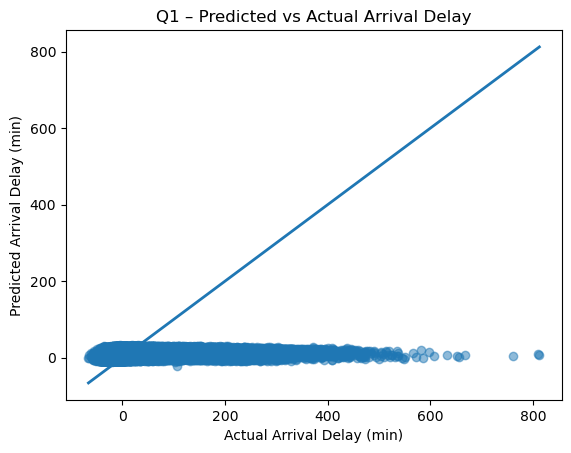

In [ ]:
# Transform the preprocessor into a frozen transformer
frozen_prep_q1 = FunctionTransformer(
    func=preprocessor_q1.transform,                       
    feature_names_out=lambda *_: preprocessor_q1.get_feature_names_out(),
    validate=False
)

# Pipeline
model_q1 = Pipeline([
    ('prep', frozen_prep_q1),
    ('reg',  LinearRegression())                          
])

# Fit on q1 data
model_q1.fit(X_train_q1, y_train)

# Predict on q1 data
y_pred_q1 = model_q1.predict(X_test_q1)

# Evaluation
rmse_q1 = mean_squared_error(y_test, y_pred_q1, squared=False)
mae_q1  = mean_absolute_error(y_test, y_pred_q1)
r2_q1   = r2_score(y_test, y_pred_q1)

print(f"Q1 – Linear Regression")
print(f"   RMSE: {rmse_q1:.2f} minutes")
print(f"   MAE : {mae_q1 :.2f} minutes")
print(f"   R²  : {r2_q1  :.3f}")

# Scatter plot 
plt.figure()
plt.scatter(y_test, y_pred_q1, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], linewidth=2)
plt.xlabel('Actual Arrival Delay (min)')
plt.ylabel('Predicted Arrival Delay (min)')
plt.title('Q1 – Predicted vs Actual Arrival Delay')
plt.show()


In [33]:
# View OLS summary statistics
# Transform the training matrix 
X_train_q1_proc = preprocessor_q1.transform(X_train_q1)

# Turn the NumPy array into a DataFrame so statsmodels has column names
feat_names_q1   = preprocessor_q1.get_feature_names_out()
X_train_q1_df   = pd.DataFrame(X_train_q1_proc,
                               columns=feat_names_q1,
                               index=X_train_q1.index)

# Add an explicit intercept column 
X_train_q1_const = sm.add_constant(X_train_q1_df, has_constant='add')

# Fit OLS and print
ols_q1 = sm.OLS(y_train, X_train_q1_const).fit()
print(ols_q1.summary())

                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                 2.469e+04
Date:                Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                        13:45:53   Log-Likelihood:            -2.1839e+07
No. Observations:             4510601   AIC:                         4.368e+07
Df Residuals:                 4510584   BIC:                         4.368e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -4

In [34]:
# Compare Linear model and non-linear models

# Transform once with the frosen preprocessor
X_train_q1_proc = preprocessor_q1.transform(X_train_q1)
X_test_q1_proc  = preprocessor_q1.transform(X_test_q1)
N_test = X_test_q1_proc.shape[0]

# Define the models
models = {
    "Linear": (LinearRegression(),      X_train_q1_proc, X_test_q1_proc),
    "RF"    : (RandomForestRegressor(n_estimators=50,
                                     max_depth=10,
                                     random_state=42,
                                     n_jobs=-1),
                                        X_train_q1,      X_test_q1),
    "XGB"   : (XGBRegressor(n_estimators=50,
                            random_state=42,
                            n_jobs=-1),
                                        X_train_q1,      X_test_q1)
}

# Train, time, predict, and score
for name, (mdl, Xtr, Xte) in models.items():
    t0 = time.perf_counter()
    mdl.fit(Xtr, y_train)
    train_time = time.perf_counter() - t0

    t1 = time.perf_counter()
    y_pred = mdl.predict(Xte)
    infer_time = time.perf_counter() - t1

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f"{name:6}"
          f" | train: {train_time:5.2f}s"
          f" | infer: {infer_time:5.2f}s"
          f" ({infer_time / N_test * 1e3:6.3f} ms/sample)"
          f" | RMSE = {rmse:6.2f} min"
          f" | MAE = {mae:6.2f} min"
          f" | R² = {r2:5.3f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear | train:  1.27s | infer:  0.02s ( 0.000 ms/sample) | RMSE =  33.76 min | MAE =  21.65 min | R² = 0.055


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RF     | train: 112.71s | infer:  0.37s ( 0.000 ms/sample) | RMSE =  33.51 min | MAE =  20.60 min | R² = 0.069
XGB    | train:  3.53s | infer:  0.11s ( 0.000 ms/sample) | RMSE =  33.47 min | MAE =  20.26 min | R² = 0.071


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
# XGBoost model with fine-tuning
Xtr = X_train_q1          # training years
Xte = X_test_q1           # hold‑out year  
N_test = len(Xte)

# Base XGB model
xgb = XGBRegressor(
    random_state=42,
    tree_method="hist",
    n_jobs=1              
)

# Hyperparameter grid
param_dist = {
    'n_estimators':     [50, 100, 200],
    'max_depth':        [3, 5, 6, 7],
    'learning_rate':    [0.01, 0.05, 0.1, 0.3],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


# time series cross‑validation
tscv = TimeSeriesSplit(n_splits=3)

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,                                
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    return_train_score=True
)

# fit and time
t0 = time.perf_counter()
rs.fit(Xtr, y_train)
train_time = time.perf_counter() - t0

# Best parameters and cv score
print(f"\nGrid‑search finished in {train_time:.1f}s")
print(f"Best CV RMSE: {-rs.best_score_:.3f}")
print("Best parameters:")
for p, v in rs.best_params_.items():
    print(f"   • {p}: {v}")

# Evaluation on the hold‑out set
t1 = time.perf_counter()
y_pred_xgb = rs.predict(Xte)
infer_time = time.perf_counter() - t1

rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae  = mean_absolute_error(y_test, y_pred_xgb)
r2   = r2_score(y_test, y_pred_xgb)

print("\nPerformance on 2023:")
print(f"   RMSE : {rmse:.2f} min")
print(f"   MAE  : {mae :.2f} min")
print(f"   R²   : {r2  :.3f}")
print(f"   Inference time: {infer_time:.2f}s "
      f"({infer_time / N_test * 1e3:.2f} ms/sample)")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Grid‑search finished in 217.1s
Best CV RMSE: 31.429
Best parameters:
   • subsample: 1.0
   • n_estimators: 100
   • max_depth: 6
   • learning_rate: 0.01
   • colsample_bytree: 0.8

Performance on 2023:
   RMSE : 33.56 min
   MAE  : 19.60 min
   R²   : 0.066
   Inference time: 1.15s (0.00 ms/sample)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Q1 – Top 10 features by XGB split‑frequency importance:
         feature  importance
        is_covid    0.455742
   sched_dep_sin    0.240886
   sched_arr_cos    0.084896
            year    0.066068
   sched_arr_sin    0.041585
         mon_cos    0.038545
   sched_dep_cos    0.021375
         mon_sin    0.011899
         dow_sin    0.008513
origin_delay_enc    0.007568


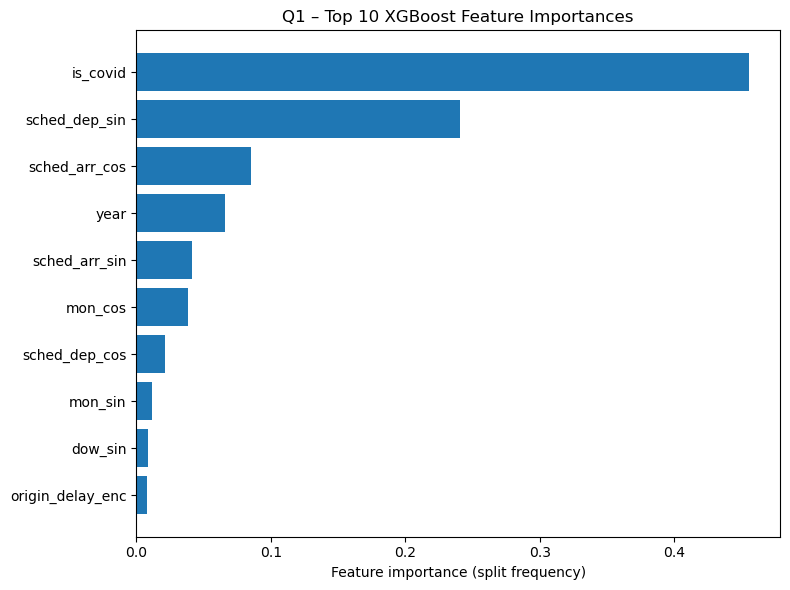

In [36]:
# Feature importances to understand the plateau

# Best model
best_xgb_q1 = rs.best_estimator_         

# Feature importances
feat_names_q1 = X_train_q1.columns.tolist()        

imp_df_q1 = (
    pd.DataFrame({
        "feature":    feat_names_q1,
        "importance": best_xgb_q1.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

# Print top 10
print("Q1 – Top 10 features by XGB split‑frequency importance:")
print(imp_df_q1.head(10).to_string(index=False))

# Plot top 10
top10 = imp_df_q1.head(10)
plt.figure(figsize=(8, 6))
plt.barh(top10["feature"][::-1], top10["importance"][::-1])
plt.xlabel("Feature importance (split frequency)")
plt.title("Q1 – Top 10 XGBoost Feature Importances")
plt.tight_layout()
plt.show()


**Subquestion 2**

In [37]:
# Fit a linear regression only on dep_delay
lin_dep_q2 = LinearRegression()          
lin_dep_q2.fit(X_train_q2[['dep_delay']], y_train)

# Predict
y_pred = lin_dep_q2.predict(X_test_q2[['dep_delay']])

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Q2 – dep_delay‑only Linear Regression")
print(f"   RMSE: {rmse:.2f} min")
print(f"   MAE : {mae :.2f} min")
print(f"   R²  : {r2  :.3f}")

Q2 – dep_delay‑only Linear Regression
   RMSE: 11.37 min
   MAE : 7.66 min
   R²  : 0.893


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
# Fit a linear regression model
lin_dep_q2 = LinearRegression()          
lin_dep_q2.fit(X_train_q2, y_train)

# Predict
y_pred = lin_dep_q2.predict(X_test_q2)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Q2 – Linear Regression")
print(f"   RMSE: {rmse:.2f} min")
print(f"   MAE : {mae :.2f} min")
print(f"   R²  : {r2  :.3f}")

Q2 – Linear Regression
   RMSE: 9.02 min
   MAE : 6.02 min
   R²  : 0.932


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
# Compare Linear model and non-linear models

# Transform once with the frosen preprocessor
X_train_q2_proc = preprocessor_q2.transform(X_train_q2)
X_test_q2_proc  = preprocessor_q2.transform(X_test_q2)
N_test = X_test_q2_proc.shape[0]

# Define the models
models = {
    "Linear": (LinearRegression(),      X_train_q2_proc, X_test_q2_proc),
    "RF"    : (RandomForestRegressor(n_estimators=50,
                                     max_depth=10,
                                     random_state=42,
                                     n_jobs=-1),
                                        X_train_q2,      X_test_q2),
    "XGB"   : (XGBRegressor(n_estimators=50,
                            random_state=42,
                            n_jobs=-1),
                                        X_train_q2,      X_test_q2)
}

# Train, time, predict, and score
preds, residuals = {}, {}

for name, (mdl, Xtr, Xte) in models.items():
    t0 = time.perf_counter()
    mdl.fit(Xtr, y_train)
    train_time = time.perf_counter() - t0

    t1 = time.perf_counter()
    y_pred = mdl.predict(Xte)
    infer_time = time.perf_counter() - t1

    preds[name]     = y_pred
    residuals[name] = y_test.values - y_pred

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f"{name:6}"
          f" | train: {train_time:5.2f}s"
          f" | infer: {infer_time:5.2f}s"
          f" ({infer_time / N_test * 1e3:6.3f} ms/sample)"
          f" | RMSE = {rmse:6.2f} min"
          f" | MAE = {mae:6.2f} min"
          f" | R² = {r2:5.3f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear | train:  1.40s | infer:  0.01s ( 0.000 ms/sample) | RMSE =   9.02 min | MAE =   6.02 min | R² = 0.932


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RF     | train: 200.89s | infer:  0.57s ( 0.001 ms/sample) | RMSE =   9.30 min | MAE =   6.41 min | R² = 0.928
XGB    | train:  4.63s | infer:  0.12s ( 0.000 ms/sample) | RMSE =   9.08 min | MAE =   6.02 min | R² = 0.932


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


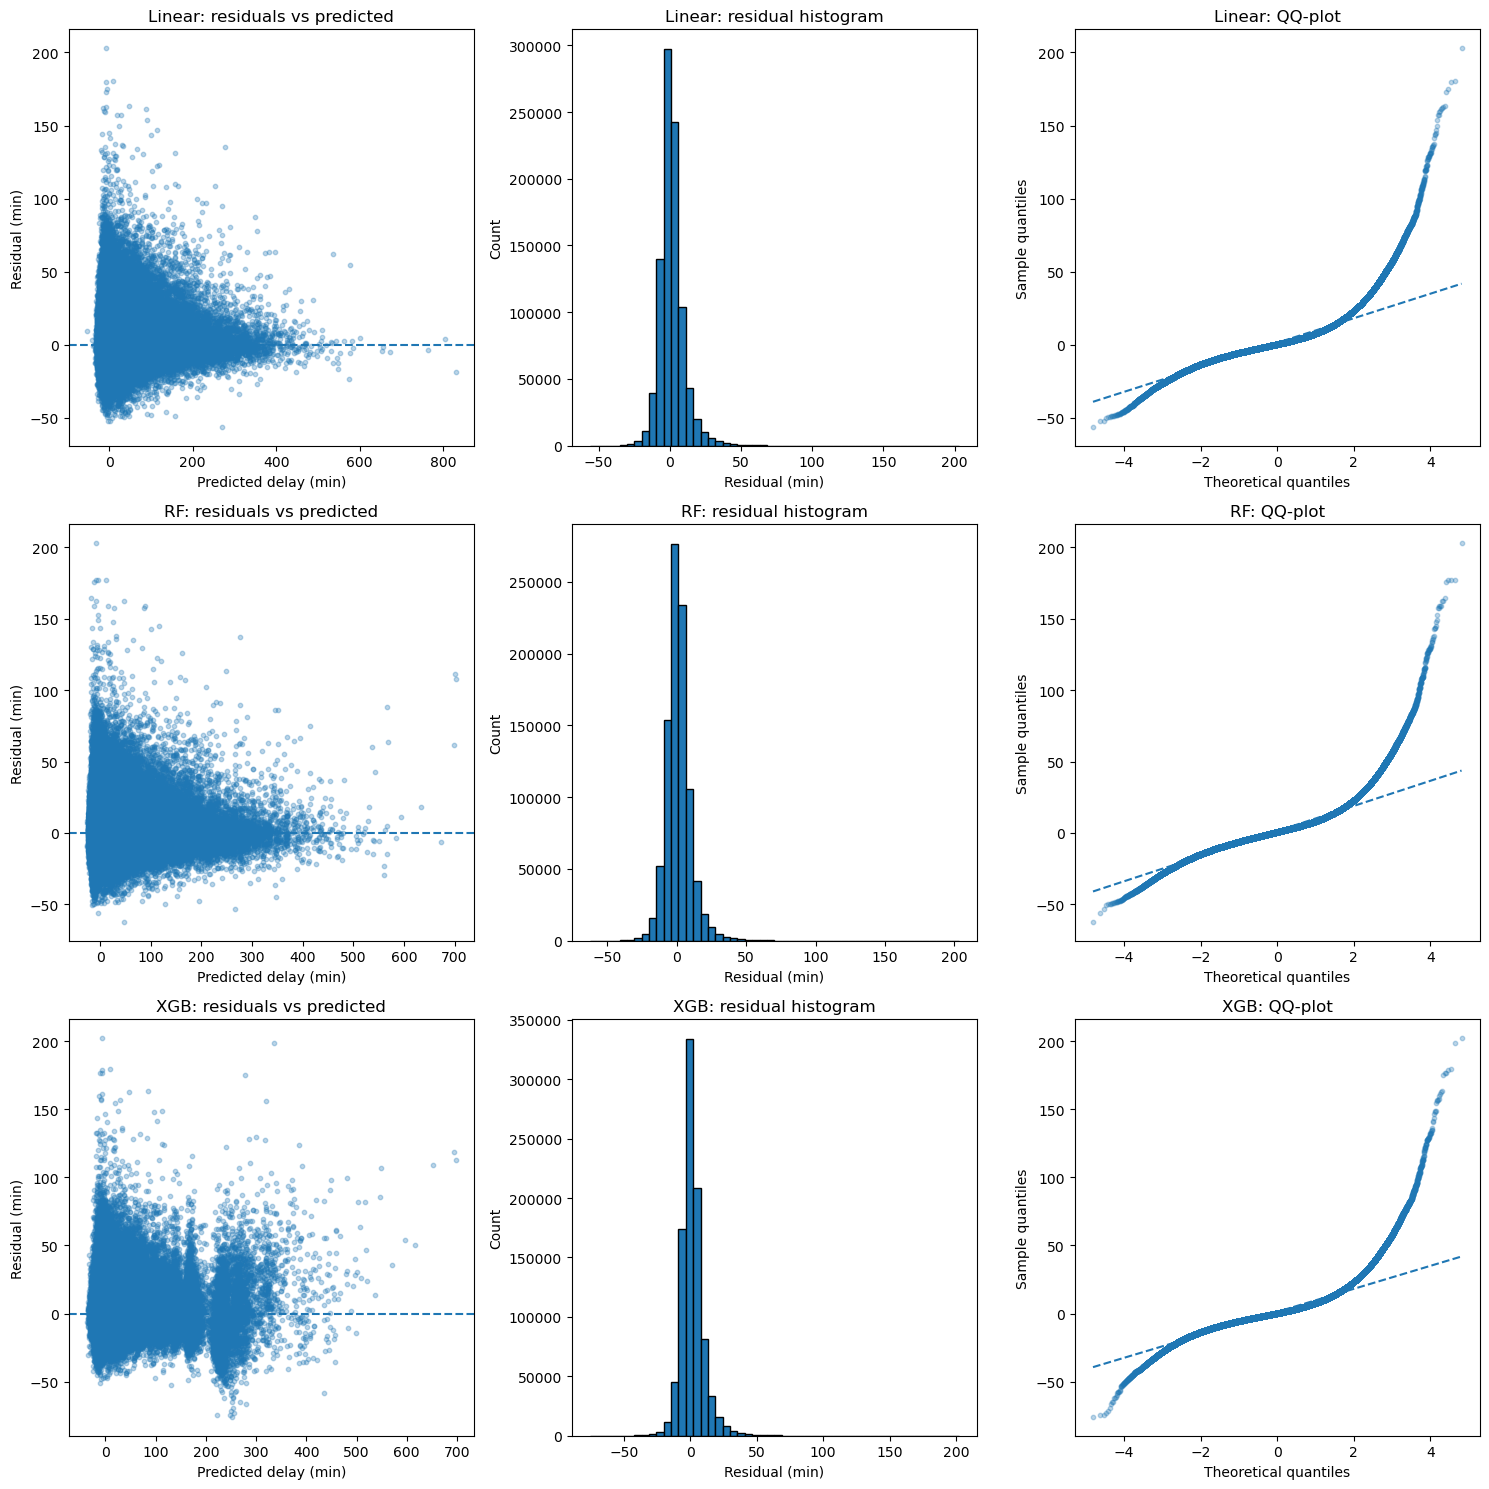

In [40]:
def qqplot_ax(data, ax, title):
    (osm, osr), (slope, intercept, _) = stats.probplot(data, dist="norm")
    ax.scatter(osm, osr, alpha=0.3, s=10)
    ax.plot(osm, slope*osm + intercept, ls="--")
    ax.set_title(title)
    ax.set_xlabel("Theoretical quantiles")
    ax.set_ylabel("Sample quantiles")

fig, axes = plt.subplots(nrows=len(models), ncols=3,
                         figsize=(15, 5 * len(models)))

for i, name in enumerate(models):
    y_hat = preds[name]
    res   = residuals[name]

    # Residuals vs fitted
    ax = axes[i, 0]
    ax.scatter(y_hat, res, alpha=0.3, s=10)
    ax.axhline(0, ls="--")
    ax.set_title(f"{name}: residuals vs predicted")
    ax.set_xlabel("Predicted delay (min)")
    ax.set_ylabel("Residual (min)")

    # Histogram
    ax = axes[i, 1]
    ax.hist(res, bins=50, edgecolor="k")
    ax.set_title(f"{name}: residual histogram")
    ax.set_xlabel("Residual (min)")
    ax.set_ylabel("Count")

    # QQ‑plot
    ax = axes[i, 2]
    qqplot_ax(res, ax, f"{name}: QQ‑plot")

plt.tight_layout()
plt.show()

In [41]:
# XGBoost model with tuning
Xtr = X_train_q2                 # training years
Xte = X_test_q2                  # hold-out year  
N_test = len(Xte)

# Base XGB model
xgb_q2 = XGBRegressor(
    tree_method="hist",
    random_state=42,
    n_jobs=1
)

# Hyperparameter grid
param_dist = {
    'n_estimators':     [50, 100, 200],
    'max_depth':        [3, 5, 6, 7],
    'learning_rate':    [0.01, 0.05, 0.1, 0.3],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Randomized search
rs_q2 = RandomizedSearchCV(
    estimator=xgb_q2,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=1,
    return_train_score=True
)

# Fit and time
t0 = time.perf_counter()
rs_q2.fit(Xtr, y_train)
train_time = time.perf_counter() - t0

# Best parameters and CV score
print(f"\nGrid‑search finished in {train_time:.1f}s")
print(f"Best CV RMSE: {-rs_q2.best_score_:.3f}")
print("Best parameters:")
for p, v in rs_q2.best_params_.items():
    print(f"   • {p}: {v}")

# Evaluation on the hold-out set
t1 = time.perf_counter()
y_pred_q2 = rs_q2.predict(Xte)
infer_time = time.perf_counter() - t1

rmse = mean_squared_error(y_test, y_pred_q2, squared=False)
mae  = mean_absolute_error(y_test, y_pred_q2)
r2   = r2_score(y_test, y_pred_q2)

print("\nPerformance on 2023:")
print(f"   RMSE : {rmse:.2f} min")
print(f"   MAE  : {mae :.2f} min")
print(f"   R²   : {r2  :.3f}")
print(f"   Inference time: {infer_time:.2f}s "
      f"({infer_time / N_test * 1e3:.2f} ms/sample)")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Grid‑search finished in 306.3s
Best CV RMSE: 8.970
Best parameters:
   • subsample: 1.0
   • n_estimators: 200
   • max_depth: 6
   • learning_rate: 0.1
   • colsample_bytree: 0.8

Performance on 2023:
   RMSE : 8.96 min
   MAE  : 5.95 min
   R²   : 0.933
   Inference time: 2.56s (0.00 ms/sample)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Top 10 features by gain:
       feature  split_importance  gain_importance
     dep_delay             965.0         0.817138
wheels_off_cos             240.0         0.043182
 sched_dep_sin             454.0         0.029889
wheels_off_sin             298.0         0.025837
      taxi_out            1119.0         0.023924
 sched_dep_cos             315.0         0.017067
   act_dep_cos             266.0         0.009168
          year             309.0         0.008304
      is_covid              81.0         0.005077
   act_dep_sin             324.0         0.004553


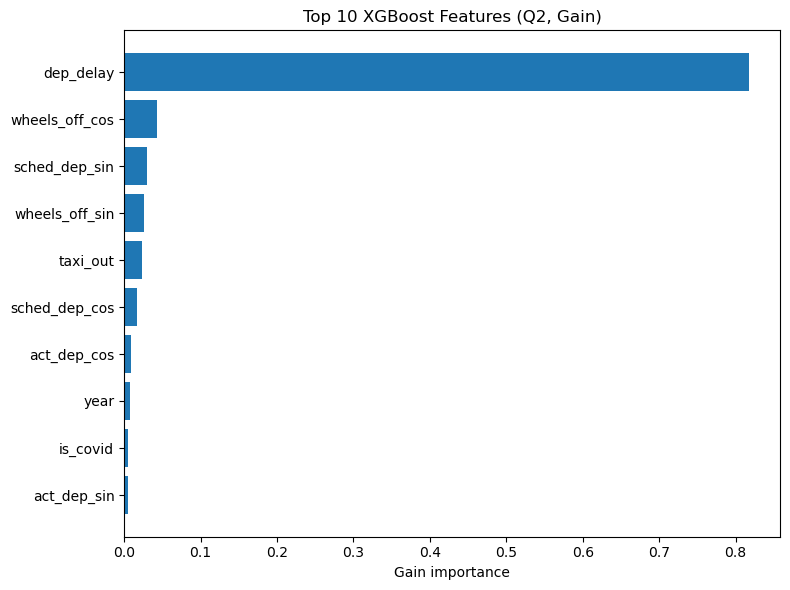

In [42]:
# Extract feature importances from the best model
best_xgb = rs_q2.best_estimator_

# Get booster and feature names
booster = best_xgb.get_booster()
feature_names_q2 = X_train_q2.columns.tolist()

# Get raw importances
split_dict = booster.get_score(importance_type="weight")
gain_dict  = booster.get_score(importance_type="gain")

# Match order to feature_names_q2
split_imp = [split_dict.get(feat, 0.0) for feat in feature_names_q2]
gain_imp  = [gain_dict.get(feat, 0.0) for feat in feature_names_q2]

# Normalize gain importance
total_gain = sum(gain_imp)
gain_imp_normalized = [g / total_gain if total_gain > 0 else 0.0 for g in gain_imp]

# Build DataFrame
imp_df_q2 = pd.DataFrame({
    "feature": feature_names_q2,
    "split_importance": split_imp,
    "gain_importance": gain_imp_normalized
}).sort_values("gain_importance", ascending=False).reset_index(drop=True)

# Display and plot
print("Top 10 features by gain:")
print(imp_df_q2.head(10).to_string(index=False))

top10 = imp_df_q2.head(10)
plt.figure(figsize=(8, 6))
plt.barh(top10["feature"][::-1], top10["gain_importance"][::-1])
plt.xlabel("Gain importance")
plt.title("Top 10 XGBoost Features (Q2, Gain)")
plt.tight_layout()
plt.show()
